# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [835]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia,...,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,Burundi,Sao Tome and Principe,South Sudan,Yemen
2020-04-19,758809,198674,178972,154097,145184,121172,86306,82211,83805,42853,...,8,9,7,7,6,5,5,4,4,1
2020-04-20,784326,200210,181228,156480,147065,125856,90980,83505,83817,47121,...,9,9,7,7,6,5,5,4,4,1
2020-04-21,823786,204178,183957,159297,148291,130172,95591,84802,83853,52763,...,9,9,7,7,6,6,5,4,4,1


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Dominica,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,Sao Tome and Principe,Seychelles,Sierra Leone,Chad,Central African Republic,Rwanda
2020-04-19,40661,23660,20453,19744,16095,5683,5118,4586,4636,3697,...,0,0,0,0,0,0,0,0,0,0
2020-04-20,42094,24114,20852,20292,16550,5828,5209,4862,4636,3764,...,0,0,0,0,0,0,0,0,0,0
2020-04-21,44845,24648,21282,20829,17378,5998,5297,5033,4636,3929,...,0,0,0,0,0,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [836]:

df_rolls = dfc_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(columns={df_rolls.columns[0]:'Cases3dayAvg'})
df_rolls['Cases7dayAvg'] = dfc_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Cases14dayAvg'] = dfc_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls['Deaths3dayAvg'] = dfd_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls['Deaths7dayAvg'] = dfd_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Deaths14dayAvg'] = dfd_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(index={'US':'United States'})
df_rolls.head()


,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,
United States,30529.666667,30873.714286,30476.071429,2060.333333,2714.571429,2289.357143
Spain,4150.666667,4519.571429,4445.428571,413.000000,460.857143,516.928571
Italy,2677.333333,3067.000000,3455.071429,473.666667,511.571429,537.214286
France,3382.666667,3990.857143,5723.857143,494.666667,725.857143,749.000000
Germany,1649.666667,2418.857143,2902.000000,191.333333,248.428571,215.500000


## Add Global Population by Country

In [837]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })

# merge rolling averages
df_gmerged = pd.merge(left=df_gmerged, right=df_rolls, on='Country/Region')
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(10))  

display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
7,China,4636,83853,CHN,2016,1378665000,22.000000,78.142857,81.071429,0.000000,184.428571,92.928571
17,India,645,20080,IND,2016,1324509589,1452.666667,1227.571429,1054.928571,41.333333,36.000000,35.357143
0,United States,44845,823786,USA,2016,322941311,30529.666667,30873.714286,30476.071429,2060.333333,2714.571429,2289.357143
18,Indonesia,616,7135,IDN,2016,261554226,295.666667,328.000000,314.071429,27.000000,22.428571,28.214286
9,Brazil,2741,43079,BRA,2016,206163058,2140.333333,2545.285714,2074.642857,129.000000,172.714286,146.785714
30,Pakistan,201,9565,PAK,2016,203627284,642.333333,532.571429,395.000000,19.333333,15.000000,10.285714
71,Nigeria,22,665,NGA,2016,185960289,41.000000,41.714286,29.357143,1.000000,1.571429,1.142857
42,Bangladesh,110,3382,BGD,2016,157970840,412.666667,338.571429,229.857143,8.666667,9.142857,6.642857
27,Japan,263,11135,JPN,2016,126994511,279.666667,498.571429,516.357143,13.666667,17.142857,12.214286
16,Mexico,712,8772,MEX,2016,123333376,632.333333,536.857143,452.357143,55.333333,54.285714,41.928571


2020-01-22    185
dtype: int64

159

## Add Various Other Data from WorldBank.Org

In [838]:
# all available indicators https://data.worldbank.org/indicator
#    API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#    I should bundle into a single request XLS or Json results, but alas.. this works for now
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [863]:
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False) # 0 data for g10's
#df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('IS.SHP.GOOD.TU', 'shipping', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.LE00.IN', 'lifeExpYrs', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FP.CPI.TOTL.ZG', 'inflation', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.TFRT.IN', 'fertility', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)


df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])

df_gmerged3.head()


,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,44845,823786,USA,322941311,30529.666667,30873.714286,30476.071429,2060.333333,2714.571429,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
2,Spain,21282,204178,ESP,46484062,4150.666667,4519.571429,4445.428571,413.000000,460.857143,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67
1,Italy,24648,183957,ITA,60627498,2677.333333,3067.000000,3455.071429,473.666667,511.571429,...,205.45,41830.43,10547112.0,82.95,0.61,1.32,4.9,95.0,22.75,50.26
3,France,20829,159297,FRA,66721256,3382.666667,3990.857143,5723.857143,494.666667,725.857143,...,122.34,45342.40,6369200.0,82.53,1.11,1.90,6.0,96.0,20.03,45.16
6,Germany,5033,148291,DEU,82348669,1649.666667,2418.857143,2902.000000,191.333333,248.428571,...,237.37,53074.54,19597633.0,80.99,1.45,1.56,4.8,93.0,21.46,72.11


In [865]:
df_gmerged3.head(10).transpose()

,0,2,1,3,6,4,10,7,9,5
Country/Region,United States,Spain,Italy,France,Germany,United Kingdom,Turkey,China,Brazil,Belgium
Deaths,44845,21282,24648,20829,5033,17378,2259,4636,2741,5998
Cases,823786,204178,183957,159297,148291,130172,95591,83853,43079,40956
Country Code,USA,ESP,ITA,FRA,DEU,GBR,TUR,CHN,BRA,BEL
Population,322941311,46484062,60627498,66721256,82348669,65611593,79821724,1378665000,206163058,11331422
Cases3dayAvg,30529.7,4150.67,2677.33,3382.67,1649.67,4952.67,4420.67,22,2140.33,1257.67
Cases7dayAvg,30873.7,4519.57,3067,3990.86,2418.86,5046.71,4354.29,78.1429,2545.29,1405.29
Cases14dayAvg,30476.1,4445.43,3455.07,5723.86,2902,5301.64,4391.57,81.0714,2074.64,1340.14
Deaths3dayAvg,2060.33,413,473.667,494.667,191.333,626.667,123,0,129,181.667
Deaths7dayAvg,2714.57,460.857,511.571,725.857,248.429,749.857,122.286,184.429,172.714,263


# Correlation Matrix

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.924736,0.179280,0.849512,0.861624,0.879427,0.940684,0.933444,0.956798,0.728079,...,-0.025872,0.249353,0.278019,0.174879,-0.042653,-0.165338,-0.159934,0.090017,0.305885,-0.078415
Cases,0.924736,1.000000,0.222132,0.971503,0.977850,0.982673,0.978640,0.981081,0.969913,0.880891,...,-0.023408,0.245582,0.322110,0.148649,-0.033350,-0.148574,-0.148778,0.082273,0.245441,-0.089882
Population,0.179280,0.222132,1.000000,0.181798,0.178577,0.173156,0.155335,0.194251,0.172011,0.503798,...,-0.017312,-0.042647,0.737882,0.022458,0.003732,-0.049331,-0.018070,0.029798,0.010736,-0.141224
Cases3dayAvg,0.849512,0.971503,0.181798,1.000000,0.999203,0.995663,0.968301,0.968932,0.948117,0.879820,...,-0.012652,0.219940,0.236633,0.116231,-0.023455,-0.120008,-0.119748,0.066504,0.174257,-0.086232
Cases7dayAvg,0.861624,0.977850,0.178577,0.999203,1.000000,0.997965,0.973735,0.974395,0.955155,0.879565,...,-0.015822,0.224981,0.238848,0.122283,-0.025006,-0.125182,-0.125073,0.067802,0.188533,-0.087927
Cases14dayAvg,0.879427,0.982673,0.173156,0.995663,0.997965,1.000000,0.980448,0.982102,0.966275,0.872898,...,-0.019335,0.228865,0.236836,0.127889,-0.026186,-0.127734,-0.129729,0.070961,0.202252,-0.089996
Deaths3dayAvg,0.940684,0.978640,0.155335,0.968301,0.973735,0.980448,1.000000,0.995874,0.994800,0.838536,...,-0.025075,0.239716,0.227742,0.143827,-0.034043,-0.138632,-0.137947,0.074091,0.246924,-0.087059
Deaths7dayAvg,0.933444,0.981081,0.194251,0.968932,0.974395,0.982102,0.995874,1.000000,0.994988,0.865525,...,-0.024120,0.232847,0.284554,0.138354,-0.033493,-0.134018,-0.135522,0.075063,0.237545,-0.086831
Deaths14dayAvg,0.956798,0.969913,0.172011,0.948117,0.955155,0.966275,0.994800,0.994988,1.000000,0.825869,...,-0.024461,0.241827,0.256661,0.149456,-0.036079,-0.142053,-0.142119,0.079006,0.257897,-0.081486
flights,0.728079,0.880891,0.503798,0.879820,0.879565,0.872898,0.838536,0.865525,0.825869,1.000000,...,-0.024821,0.222829,0.616782,0.137851,-0.034368,-0.154357,-0.146960,0.089789,0.181807,-0.101634


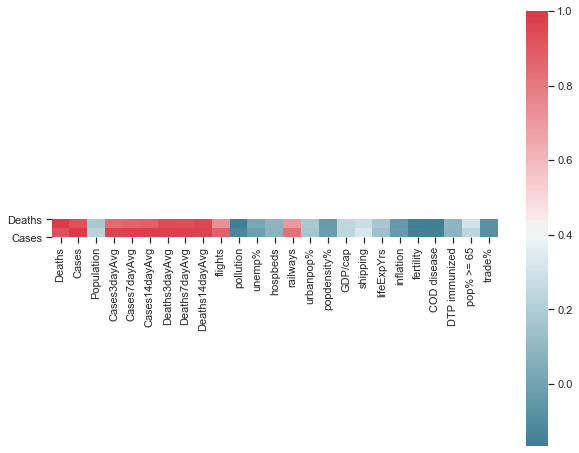

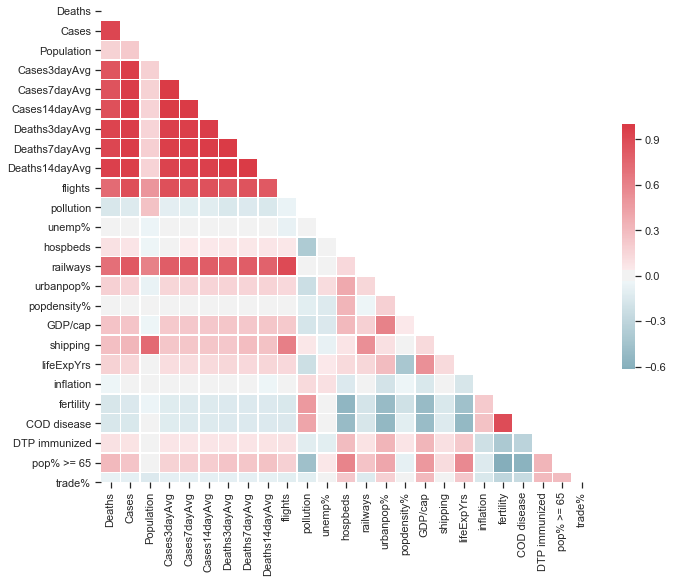

In [866]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [867]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_sc = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
display('orig',df_sc.head(2))

df_sc = pd.DataFrame(scaler.fit_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
display('scale',df_sc.head(2))

# df_sc = pd.DataFrame(scaler.inverse_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
# display('inverse',df_sc.head(2))

'orig'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,44845,823786,322941311,30529.666667,30873.714286,30476.071429,2060.333333,2714.571429,2289.357143,9879630.0,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
Spain,21282,204178,46484062,4150.666667,4519.571429,4445.428571,413.000000,460.857143,516.928571,641020.0,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67


'scale'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,9.014499,11.335596,1.809402,11.989737,11.924714,11.796667,11.152873,11.292131,10.758828,10.876939,...,-0.183451,1.814318,2.659138,0.602804,-0.184723,-0.688895,-0.772788,0.406128,1.074007,-1.121848
Spain,4.162011,2.650556,0.026889,1.469635,1.583093,1.555978,2.078728,1.759574,2.274712,0.472386,...,-0.148344,0.800173,0.673656,1.031370,-0.256791,-1.013030,-0.777583,0.350364,1.614246,-0.266125


# Misc Clustering Techniques

## - Basic Template for KMeans

In [868]:
from sklearn.model_selection import train_test_split

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


'kmeans info - inertia: 2168.2790483717354, iters: 13'

'labels: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1\n 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0\n 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0\n 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1\n 0 1 1 1 1 0 0 1 0 0 0]'

'train'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,2,9.014499,11.335596,1.814318,2.659138,0.602804,-0.184723,-0.688895,-0.772788,0.406128,1.074007,-1.121848
Spain,1,4.162011,2.650556,0.800173,0.673656,1.031370,-0.256791,-1.013030,-0.777583,0.350364,1.614246,-0.266125
Italy,1,4.855194,2.367119,0.893110,0.321940,0.997371,-0.262634,-1.005312,-0.787174,0.461891,2.124220,-0.305249
France,1,4.068721,2.021460,1.047433,0.100727,0.959793,-0.230171,-0.557698,-0.734424,0.517655,1.712609,-0.446759
Germany,1,0.815744,1.867189,1.387199,0.801148,0.822008,-0.208097,-0.820092,-0.791969,0.350364,1.929007,0.301027
United States,2,9.014499,11.335596,1.814318,2.659138,0.602804,-0.184723,-0.688895,-0.772788,0.406128,1.074007,-1.121848
Spain,1,4.162011,2.650556,0.800173,0.673656,1.031370,-0.256791,-1.013030,-0.777583,0.350364,1.614246,-0.266125
Italy,1,4.855194,2.367119,0.893110,0.321940,0.997371,-0.262634,-1.005312,-0.787174,0.461891,2.124220,-0.305249
China,1,0.733987,0.963962,-0.143651,11.720718,0.438177,-0.113955,-0.719765,-0.839924,0.684946,0.334015,-0.757250


,Cases
cluster,
0,57
1,101
2,1


## - Basic Template for DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [869]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


"model: DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=2, n_jobs=None, p=None)"

'core_sample_indices_[0:10]: [ 1  2  3  5  9 11 12 13 15 16]'

'components_[0]: [ 4.16201065  2.65055635  0.02688869  1.46963507  1.58309318  1.55597829\n  2.07872791  1.75957428  2.27471234  0.47238554 -0.89488095  1.37071175\n  0.06010084  0.68698041  0.87168744 -0.1483439   0.80017278  0.67365564\n  1.03137026 -0.25679087 -1.0130297  -0.77758298  0.35036395  1.61424593\n -0.26612507]'

'labels/fit_predict[0:10]: [-1  0  0  0 -1  0 -1 -1 -1  1]'

'train2'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,-1,9.014499,11.335596,1.814318,2.659138,0.602804,-0.184723,-0.688895,-0.772788,0.406128,1.074007,-1.121848
Spain,0,4.162011,2.650556,0.800173,0.673656,1.031370,-0.256791,-1.013030,-0.777583,0.350364,1.614246,-0.266125
Italy,0,4.855194,2.367119,0.893110,0.321940,0.997371,-0.262634,-1.005312,-0.787174,0.461891,2.124220,-0.305249
France,0,4.068721,2.021460,1.047433,0.100727,0.959793,-0.230171,-0.557698,-0.734424,0.517655,1.712609,-0.446759
Germany,-1,0.815744,1.867189,1.387199,0.801148,0.822008,-0.208097,-0.820092,-0.791969,0.350364,1.929007,0.301027
United States,-1,9.014499,11.335596,1.814318,2.659138,0.602804,-0.184723,-0.688895,-0.772788,0.406128,1.074007,-1.121848
Spain,0,4.162011,2.650556,0.800173,0.673656,1.031370,-0.256791,-1.013030,-0.777583,0.350364,1.614246,-0.266125
Italy,0,4.855194,2.367119,0.893110,0.321940,0.997371,-0.262634,-1.005312,-0.787174,0.461891,2.124220,-0.305249
China,-1,0.733987,0.963962,-0.143651,11.720718,0.438177,-0.113955,-0.719765,-0.839924,0.684946,0.334015,-0.757250


,Count
cluster,
-1,14
0,4
1,139
2,2


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

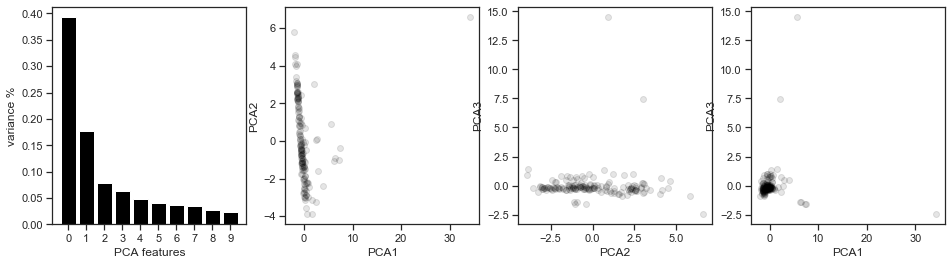

In [870]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



## KMeans on PCA data

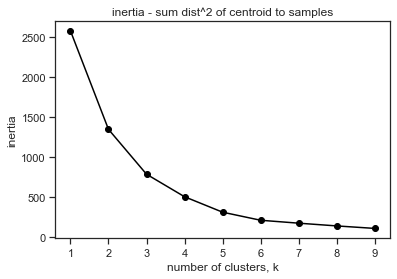

In [871]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

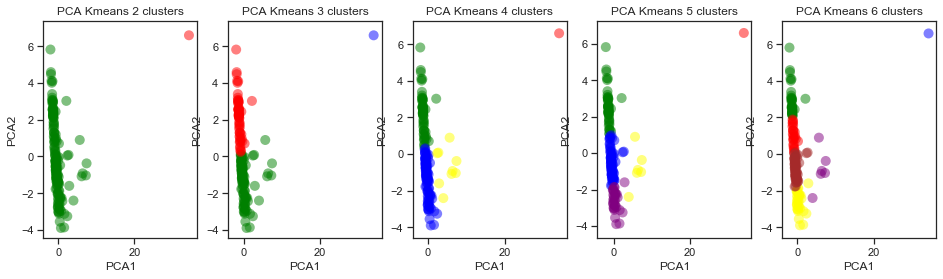

In [872]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
        m = model.fit(df_comp2.iloc[:,:dims])
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

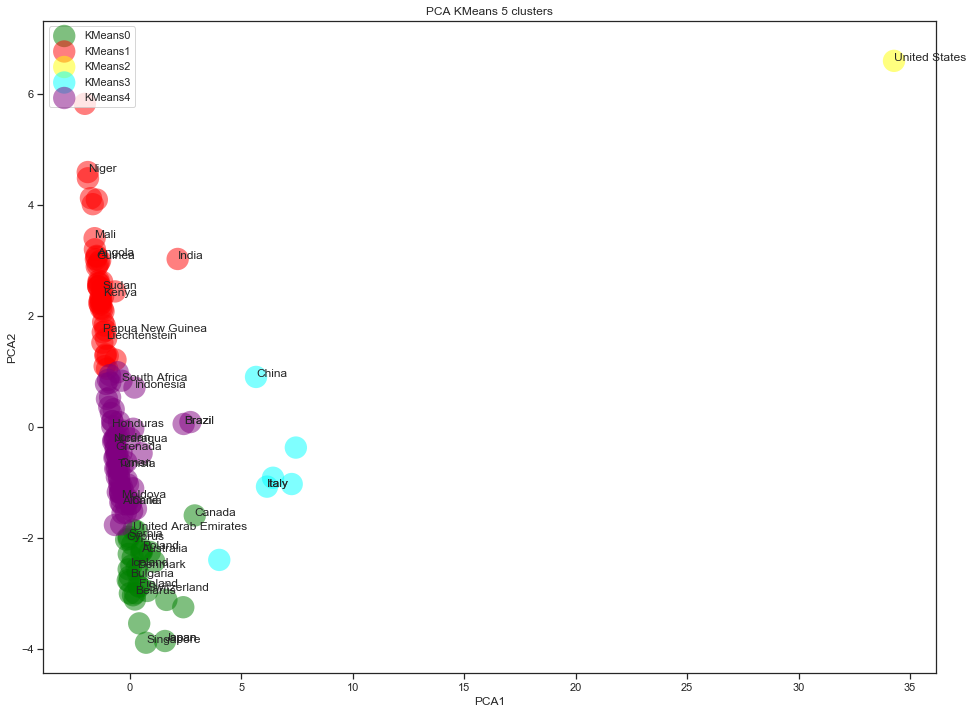

In [873]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2.iloc[:,:dims])  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(tsne_comps):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['China','Canada','Japan','United States','Singapore','South Africa','Belarus','Brazil','Italy','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(countries).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=2)
    plt.show()
    
# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','PCA',model, PCA_components)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

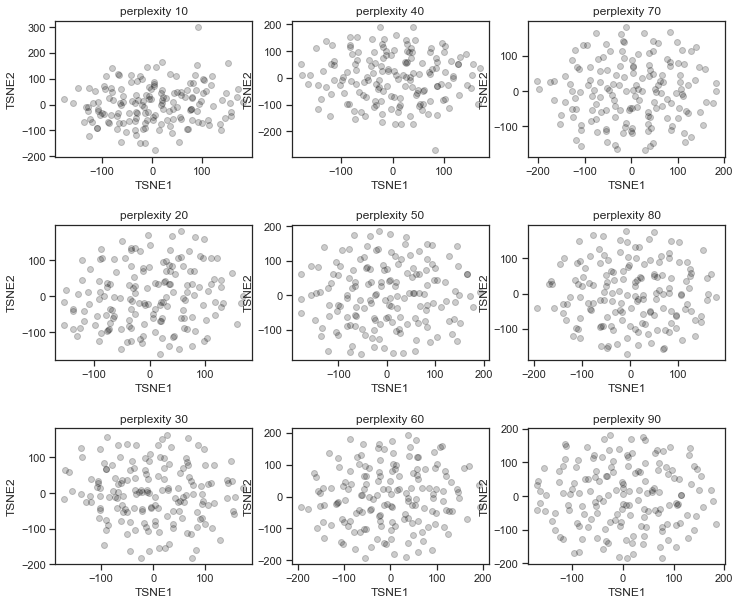

In [874]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=3, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [875]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne_comps = 2
tsne_perp = 30
tsne = TSNE(n_components=tsne_comps, perplexity=tsne_perp)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,10.563203,-1.222028
Spain,10.562576,-0.261372
Italy,10.566837,-0.238621
France,10.566390,-0.345946
Germany,7.028831,6.121360


## KMeans w/ TSNE

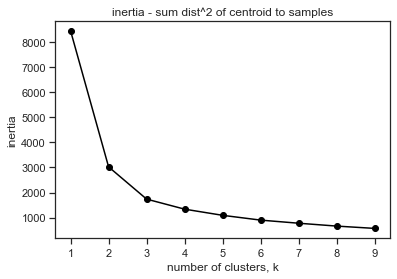

In [876]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

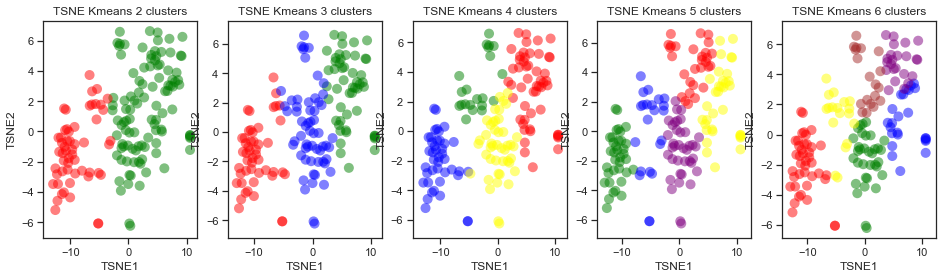

In [877]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

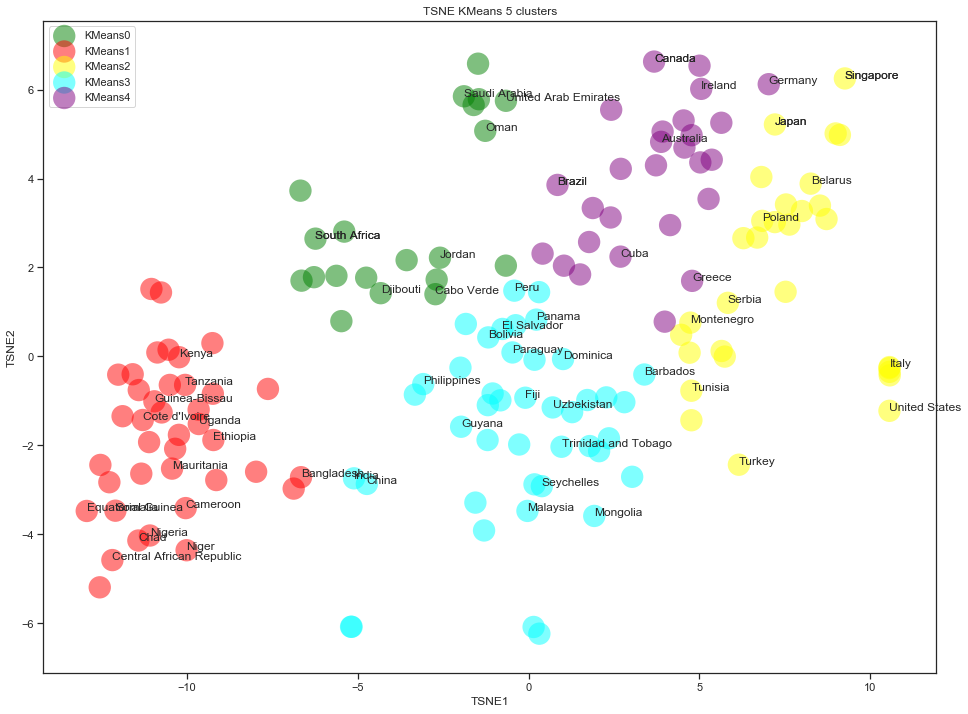

In [882]:
# try 6 clusters -- why i dunno, looks good... 
clusters = 5
model = KMeans(n_clusters=clusters)            

plot_big('KMeans','TSNE',model, TSNE_components, countries=50)

---
## DBScan on PCA Cluster Analysis


"model: DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=1, n_jobs=None, p=None)"

'distinct labels: ct: 30 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} '

'labels/fit_predict[0:10]: [ 0  1  1  1  2  1  3  4  5  6  7  6  8  8  9  8  8  8  8  8 10 11  8  8\n  8  8  8 12  8  8 13  8  8  8  8  8  8 14 15  8  8  8  8  8  8 16  8  8\n  8  8  8  8  8  8 10  8 10  8  8  8  8  8 10  8  8  8  8  8  8  8  8  8\n  8  8  8  8  8  8  8  8 17  8  8  8  8 18  8  8  8  8 19  8 20 21  8  8\n  8  8  8  8  8  8  8 22 23  8  8  8  8  8 24  8 25  8  8  8  8  8 26  8\n 27  8 19  8  8  8  8  8 28  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8\n  8  8  8  8  8  8  8  8  8  8  8  8  8  8 29]'

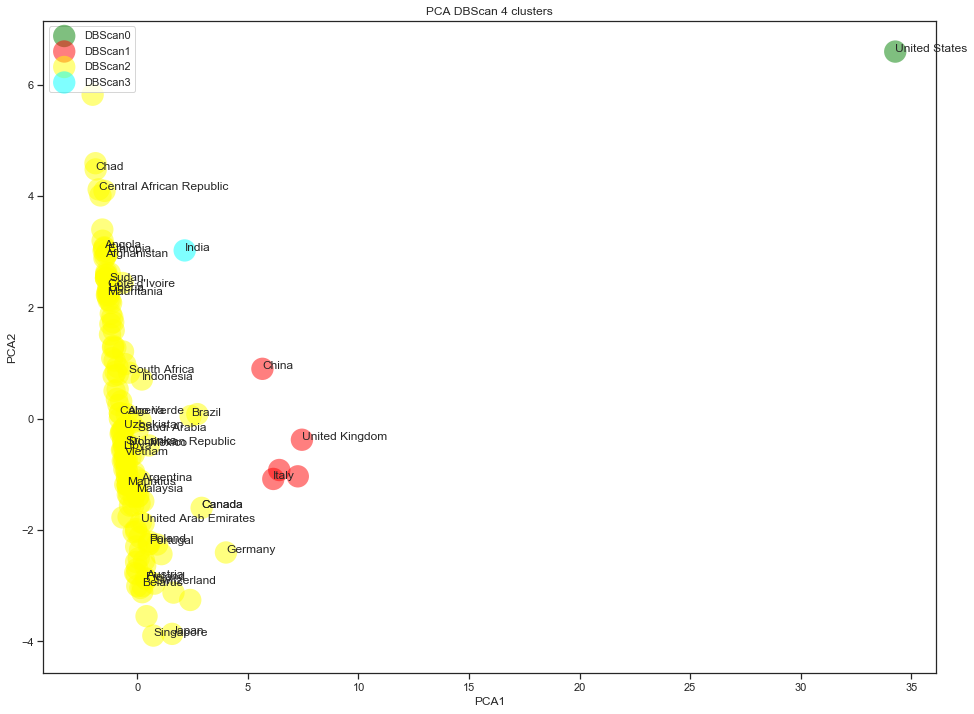

In [879]:

from sklearn.cluster import DBSCAN
import numpy as np

PCA_components3 = PCA_components.copy()
clustering = DBSCAN(eps=2, min_samples=1).fit(PCA_components3)
components = clustering.components_
labels = clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
display(f'distinct labels: ct: {len(set(labels))} - {set(labels)} ')
#display(f'core_sample_indices_[0:10]: {core_sample_indices}')
#display(f'components_[0]: {components}')    
display(f'labels/fit_predict[0:10]: {labels}')                       
#display('PCA_components3',PCA_components3)
    
plot_big('DBScan','PCA',clustering, PCA_components3)


## DBScan on TSNE Cluster Analysis

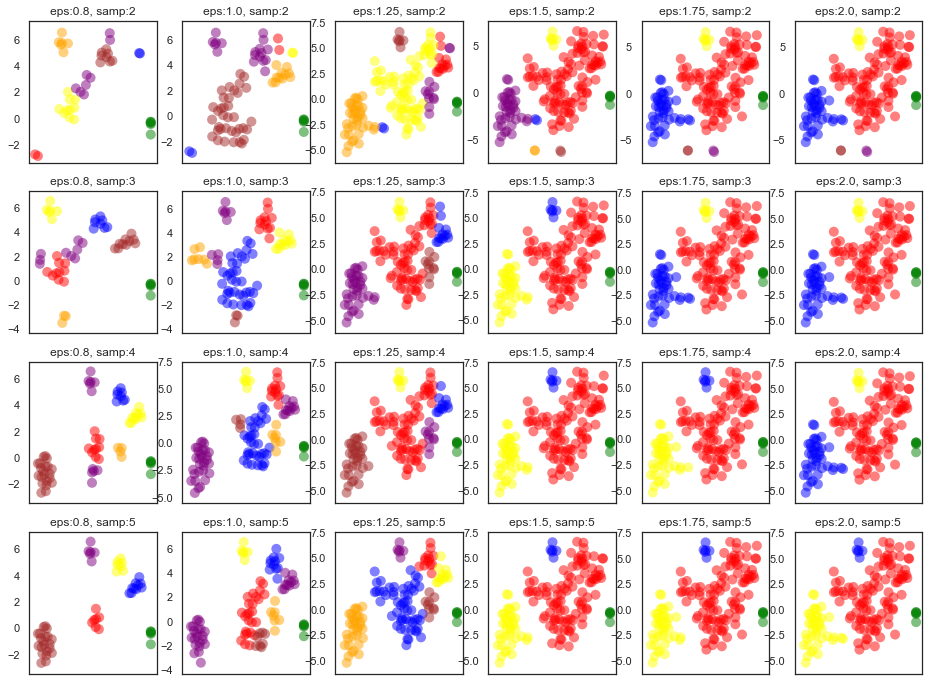

In [880]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product

# try a variety of eps & samples 
samp_list = [2,3,4,5]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75, 2.0]

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

rl = len(samp_list)

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rl][math.floor(k/rl)].tick_params(
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False) # labels along the bottom edge are off

    TSNE_components3 = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_components3)
    TSNE_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))): 
        tup = []
        for j in range(2):  ## should be cluster dims? pca dims?
            tup.append(TSNE_components3[TSNE_components3['cluster']==i][j])
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rl][math.floor(k/rl)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rl][math.floor(k/rl)].set_title(f'eps:{eps}, samp:{samp}')


"model: DBSCAN(algorithm='auto', eps=1.25, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=4, n_jobs=None, p=None)"

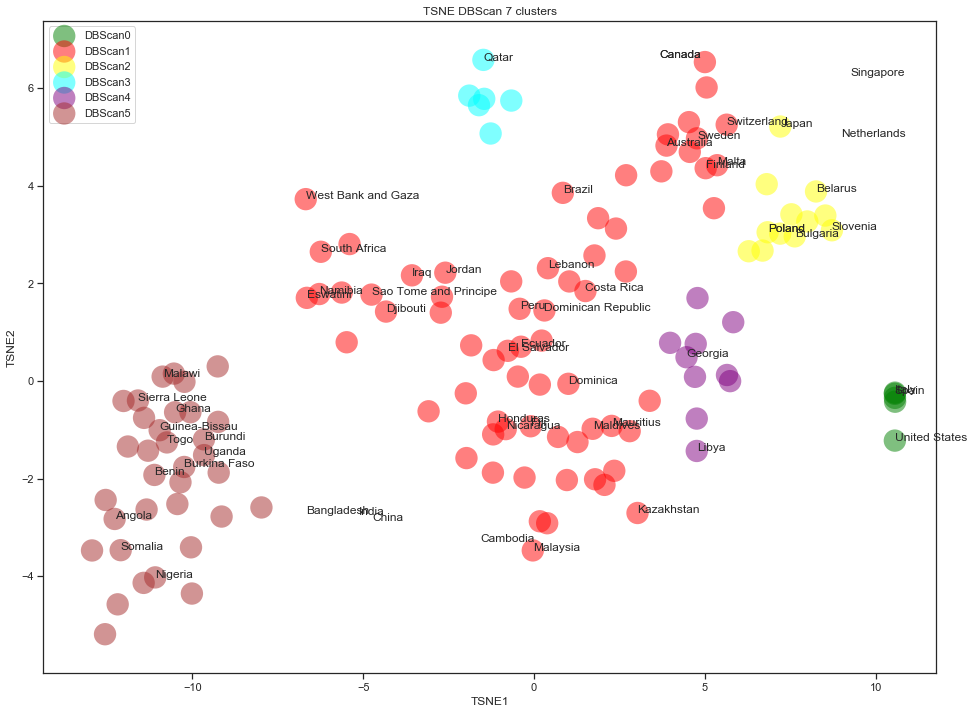

In [887]:

TSNE_components3 = TSNE_components.copy()
clustering = DBSCAN(eps=1.25, min_samples=4).fit(TSNE_components3)
components = clustering.components_
labels = clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
plot_big('DBScan','TSNE',clustering, TSNE_components3, countries=50)